In [2]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

In [10]:
class Params:
    def __init__(self,Func,samp_size,Y):
        if Func == 'Quick':            
            epochs = 1000
            reps = 10
            N = 300
            T = 6
        elif Func == 'Full':
            epochs = 2000
            reps = 100
            N = 200
            T = 12
        else:
            epochs = 10
            reps = 3
            N = 60
            T = 1
        self.params = {}
        self.params['T'] = T
        self.params['N'] = N
        self.params['reps'] = reps
        self.params['epochs'] = epochs
        self.params['Y'] = Y
        self.params['proc']=1

rpms = Params('temp',25,'ch4_flux')
params=rpms.params
print(params)

{'T': 1, 'N': 60, 'reps': 3, 'epochs': 10, 'Y': 'ch4_flux', 'proc': 1}


In [11]:
class ReadStandardTime:
    def __init__(self,Path):
        self.Master = pd.read_csv(Path,delimiter = ',',header = 0,na_values = -9999)
        self.Master = self.Master.set_index(pd.DatetimeIndex(pd.to_datetime(self.Master['datetime'])))
        self.Master['DOY'] = self.Master.index.dayofyear*1.0
        self.Master['HR'] = self.Master.index.hour*1.0
        
    def Scale(self,y_var,X_vars):
        self.y_var = y_var
        self.Data = self.Master[np.isfinite(self.Master[y_var])]
        self.Data = self.Data.interpolate().bfill()
        self.Data = self.Data.interpolate().ffill()
        self.y = self.Data[y_var].values
        YStandard = StandardScaler()
        self.YScaled = YStandard.fit(self.y.reshape(-1, 1))
        Yscale = self.YScaled.transform(self.y.reshape(-1, 1))
        self.y = np.ndarray.flatten(Yscale)
        self.Ytru = self.YScaled.inverse_transform(self.y.reshape(-1,1))
        X = self.Data[X_vars]
        self.input_shape = len(X_vars)
        XStandard = StandardScaler()
        self.XScaled= XStandard.fit(X)
        self.X = self.XScaled.transform(X)
        Filling = self.Master[X_vars]
        Filling = Filling.interpolate().bfill()
        Filling = Filling.interpolate().ffill()
        XStandard = StandardScaler()
        self.XFillScaled= XStandard.fit(Filling)
        self.X_fill = self.XScaled.transform(Filling)
        
    def TimeShape(self,rolls):
        X1 = self.X
        Xf = self.X_fill
        self.X_time = np.zeros(shape = (X1.shape[0],rolls+1,X1.shape[1]))
        self.X_time[:,0,:] = X1
        self.X_ftime = np.zeros(shape = (Xf.shape[0],rolls+1,Xf.shape[1]))
        self.X_ftime[:,0,:] = Xf
        if rolls > 0:
            for roll in range(0,rolls):
                X2 = np.roll(X1,(roll+1),axis=0)
                X2f = np.roll(Xf,(roll+1),axis=0)
                self.X_time[:,roll+1,:] = X2
                self.X_ftime[:,roll+1,:] = Xf
        self.X_time = self.X_time[rolls+1:,:,:]
        self.X_ftime = self.X_ftime[rolls+1:,:,:]
        self.y_time = self.y[rolls+1:]
        self.y_ftime = self.y[rolls+1:]
        self.TimeSteps = rolls+1
        
    def Fill(self,Y_Pred):
        Y_fill = self.YScaled.inverse_transform(Y_Pred.reshape(-1,1))
        nanz = np.zeros(shape=(self.TimeSteps,1))
        nanz[:,:] = np.nan
        Y_Pred = np.concatenate((nanz,Y_fill),axis=0).reshape(-1,1)
        self.Master['TempFIll'] = Y_Pred
        self.Master[self.y_var+'_Filled'] = self.Master[self.y_var].fillna(self.Master['TempFIll'])

In [12]:
def LSTM_Model(Neurons,batch_size,time_steps,inputs,lr=1e-4,Memory=.9):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
#     from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = Memory
    session = tf.Session(config=config)
    model = Sequential()
    model.add(LSTM(Neurons, input_shape=(time_steps,inputs),stateful = False))
    model.add(Dense(1))
    NUM_GPU = 1 # or the number of GPUs available on your machine
    
    adam = keras.optimizers.Adam(lr = lr)
    gpu_list = []
    for i in range(NUM_GPU): gpu_list.append('gpu(%d)' % i)
    model.compile(loss='mean_squared_error', optimizer='adam')#,context=gpu_list) # - Add if using MXNET
    return(model)

def Train_Steps(epochs,Neurons,X_train,X_test,X_val,y_train,y_test,y_val,i,Memory=None):
    
    np.random.seed(i)
    from keras import backend as K
    Scorez=[]
    lr = 1e-3
    Mod = LSTM_Model(Neurons,X_train.shape[0],X_train.shape[1],X_train.shape[2],lr=lr,Memory=Memory)
    killscore=0
    killmax = 10
    e = 0
    udate = 3
    while killscore < killmax and e < epochs:
        Mod.fit(X_train,y_train,batch_size=X_train.shape[0], nb_epoch=1,shuffle=True,verbose=0)
        old_weights = Mod.get_weights()
        Y = Mod.predict(X_test,batch_size =X_test.shape[0])
        score = metrics.mean_squared_error(y_test,Y)
        Scorez.append(score)
        if e == 0:
            score_min=score
            min_weights=old_weights
        elif score < score_min:
            score_min = score
            min_weights=old_weights
            killscore = 0
        else:
            killscore +=1
        if killscore == math.floor(killmax/2):
            K.set_value(Mod.optimizer.lr, 0.5 * K.get_value(Mod.optimizer.lr))
        Mod.reset_states()
        e +=1
    Mod.set_weights(min_weights)
    Yval = Mod.predict(X_val,batch_size = X_val.shape[0])
    MSE = (metrics.mean_squared_error(y_val,Yval))
    Scorez=np.asanyarray(Scorez)
    return(MSE)
           

In [13]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor == None:
            Models.append(c)
        else:
            if factor in c:
                Models.append(c)
    return(Models)

def TTV_Split(i,Memory,X,y,params):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,y_val,i=i,Memory=Memory))

Model = ['Temp_2_5_1','u*','air_pressure','Table_1']#,'NR_Wm2_Avg','AirTC_Avg','RH','DOY']
Time = time.time()

Path = 'QuickData_FI.csv' 
def RunReps(Model,params,mp = False):
    RST = ReadStandardTime(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time*1.0
    X = RST.X_time*1.0
    MSE = []
    if __name__=='__main__'and params['proc'] != 1:
        pool = Pool(processes=params['proc'],maxtasksperchild=50)
        for i,mse in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params),range(params['reps']))):
            MSE.append(mse)
        pool.close()
    else:
        for i in range(params['reps']):
            mse = TTV_Split(i,Memory,X,y,params)
            MSE.append(mse)
    MSE = np.asanyarray(MSE)
    return(MSE)
    
Scores = []
L = len(Model)-1
Models = Combos(Model,L)
while L > 0:
    print(L,Models)
    Score = []
    for i in range(len(Models)):

        Results = RunReps(Models[i],params)
        print(Results)
        Score.append(Results)
    Score = np.asanyarray(Score)
    Worst = Models[np.where(Score == Score.max())[0][0]]
    Best = Models[np.where(Score == Score.min())[0][0]]
    Scores.append(Score)
    L-=1
    if L >1:
        for factor in Best:
            if factor not in Worst:
                print(factor)
                Models = Combos(Model,L,factor)
                print(Models)
    else:
        Models=[Best]
        

3 [['Temp_2_5_1', 'u*', 'air_pressure'], ['Temp_2_5_1', 'u*', 'Table_1'], ['Temp_2_5_1', 'air_pressure', 'Table_1'], ['u*', 'air_pressure', 'Table_1']]
[ 1.09598786  1.17067248  0.90291025]
[ 1.09194961  1.16925139  0.89491679]
[ 1.10847289  1.32037995  0.92013119]
[ 1.06031733  1.25592458  0.91385951]
u*
[['Temp_2_5_1', 'u*'], ['u*', 'air_pressure'], ['u*', 'Table_1']]
2 [['Temp_2_5_1', 'u*'], ['u*', 'air_pressure'], ['u*', 'Table_1']]
[ 1.09240426  1.17689763  0.88779862]
[ 1.06224875  1.26129125  0.90999228]
[ 1.03964686  1.26752567  0.91267845]
Temp_2_5_1
[['Temp_2_5_1']]
1 [['Temp_2_5_1']]
[ 1.11464346  1.32084876  0.91773844]
['Temp_2_5_1']


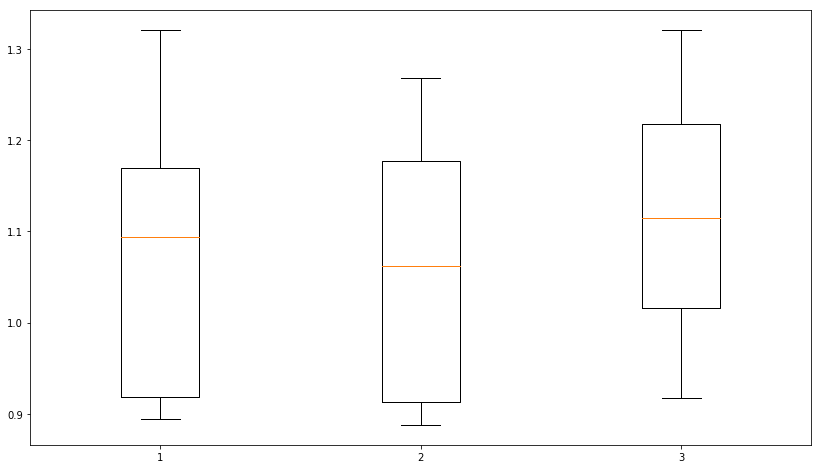

In [14]:

Scores = np.asanyarray(Scores)
# X = np.arange(0,len(Models))
# print(Best)
# print(Worst)
plt.boxplot(Scores)
plt.show()
        